In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256 # as images are 256x256 in size
BATCH_SIZE = 32 # standard batch size
CHANNELS = 3 # 3 cols: RGB
EPOCHS = 50

In [4]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "Potatos",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = data.class_names

In [6]:
# number of batches:
len(data)

68

In [7]:
for image_batch, labels_batch in data.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy()) # to convert tensor to numpy

(32, 256, 256, 3)
[0 1 1 0 0 1 2 0 1 0 1 0 2 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0 0]


As its seen above, each element of the dataset is a tuple. First element is a batch of 32 elements of images and Second is the batch of class labels of these 32 elements

# Visualizing some 12 of each class picking randomly

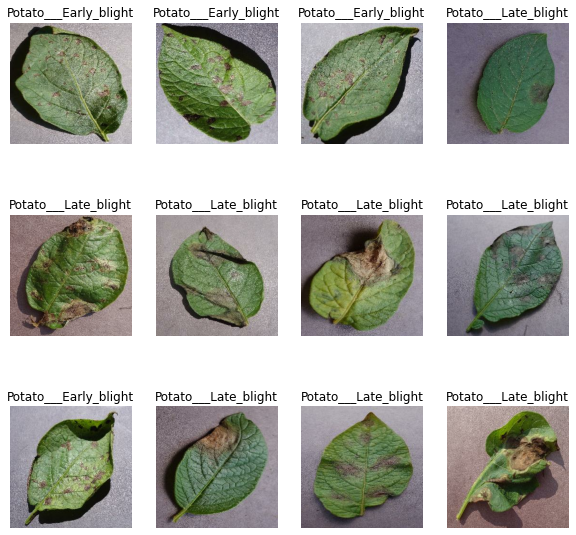

In [8]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in data.take(1): # take(1) = [:1] of entire dataset
    for i in range(12): # seeing 12 images, bcz perfect fit in screen
        ax = plt.subplot(3, 4, i+1) # plotting all 12 images
        plt.imshow(image_batch[i].numpy().astype("uint8")) # float to int
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Train-Validate-test split

we want 80% => train
rest 20% => 10% validation, 10% test

also, since there's no such thing like train_test_split() as we had in sklearn
hence we have to do it manualy

In [9]:
def get_dataset_partitions(data, train_split=0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size = 100):
    ds_size = len(data)
    
    if(shuffle):
        data = data.shuffle(shuffle_size, seed=12) # seed used to get consistent results on every run
        
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_data = data.take(train_size) # [:54]
    
    val_data = data.skip(train_size).take(val_size) # [54:6]
    test_data = data.skip(train_size).skip(val_size) #[60:]

    return train_data, val_data, test_data

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions(data)

In [11]:
len(train_ds)

54

In [12]:
len(val_ds)

6

In [13]:
len(test_ds)

8

Now caching and using prefetching to reduce time for computation

cache() -> stores the images in the ram, so that at every epoch out machine doesnt have to again-and-again read the same image from the disk

shuffle() -> decreases bias, by introducing randomness

prefetch() -> assigns Reading task for the next batch to the CPU, while GPU is training the current batch

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) # letting tf decide how many batches to be assinged to cpu
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Buidling the Model
### What if there's an image which isn't of size 256x256?
### Hence, adding an image rescaling layer and rescale all 256x256 images

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation Layer 

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

in this, we recreate existing dataset with new style, ex: rotating it, or reducing/increasing the contrast, changing lighting; by doing so we increase our training dataset and make model more robust and prevent overfitting

### Applying data augmentation

In [17]:
train_ds = train_ds.map(
        lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Using CNN as its very accurate for image classification problems**

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS) # image_batch.shape()
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape= input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(n_classes, activation="softmax") # softmax returns probability of each class
])

model.build(input_shape = input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the model

using 'adam' optimizer, 'SparseCategoricalCrossentropy' for loss and 'accuracy' as metric

In [20]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds, 
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1, # for epoch-bar animation
    epochs = EPOCHS
)

Epoch 1/50
54/54 [==============================] - 55s 982ms/step - loss: 0.8591 - accuracy: 0.5214 - val_loss: 0.8244 - val_accuracy: 0.5885
Epoch 2/50
54/54 [==============================] - 51s 949ms/step - loss: 0.5144 - accuracy: 0.7795 - val_loss: 0.6118 - val_accuracy: 0.7240
Epoch 3/50
54/54 [==============================] - 52s 957ms/step - loss: 0.2686 - accuracy: 0.8883 - val_loss: 0.2144 - val_accuracy: 0.9010
Epoch 4/50
54/54 [==============================] - 51s 950ms/step - loss: 0.1455 - accuracy: 0.9421 - val_loss: 0.1897 - val_accuracy: 0.9219
Epoch 5/50
54/54 [==============================] - 50s 917ms/step - loss: 0.1786 - accuracy: 0.9253 - val_loss: 0.1938 - val_accuracy: 0.9167
Epoch 6/50
54/54 [==============================] - 50s 927ms/step - loss: 0.1594 - accuracy: 0.9358 - val_loss: 0.1371 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 52s 958ms/step - loss: 0.0973 - accuracy: 0.9606 - val_loss: 0.0979 - val_accuracy: 0.9479

In [22]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 207ms/step - loss: 0.0841 - accuracy: 0.9766


it contains loss and accuracy value:

In [23]:
scores

[0.08406907320022583, 0.9765625]

# Plotting the Accuracy-Loss curve of the epochs using 'history'

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, val_loss, accuracy and val_accuracy are python list containg training and validation accuracy and loss at the end of each epoch**

In [25]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

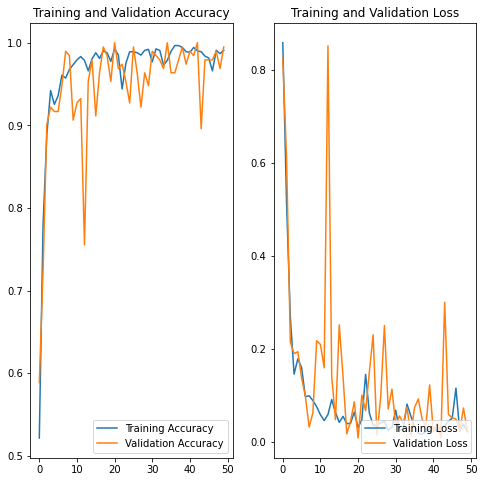

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), train_acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), train_loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.show()

### Running prediction on one sample:

first image to predict
Actual label: Potato___Early_blight
1/1 [==============================] - 0s 379ms/step
predicted label: Potato___Early_blight


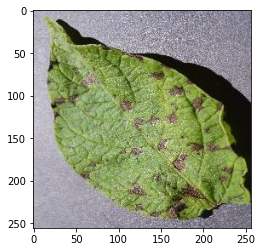

In [27]:
import numpy as np
for image_batch, labels_batch in data.take(1):
    
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print(f"Actual label: {class_names[first_label]}")
    
    batch_prediction = model.predict(image_batch)
    print(f"predicted label: {class_names[np.argmax(batch_prediction[0])]}") # As softmax returns probability to each class, hence classified class would be the one having the most probability
    

### A Fuction for the inference

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.argmax(predictions[0])), 2)
    return predicted_class, confidence

## Testing out model on some Test images

1/1 [==============================] - 0s 23ms/step


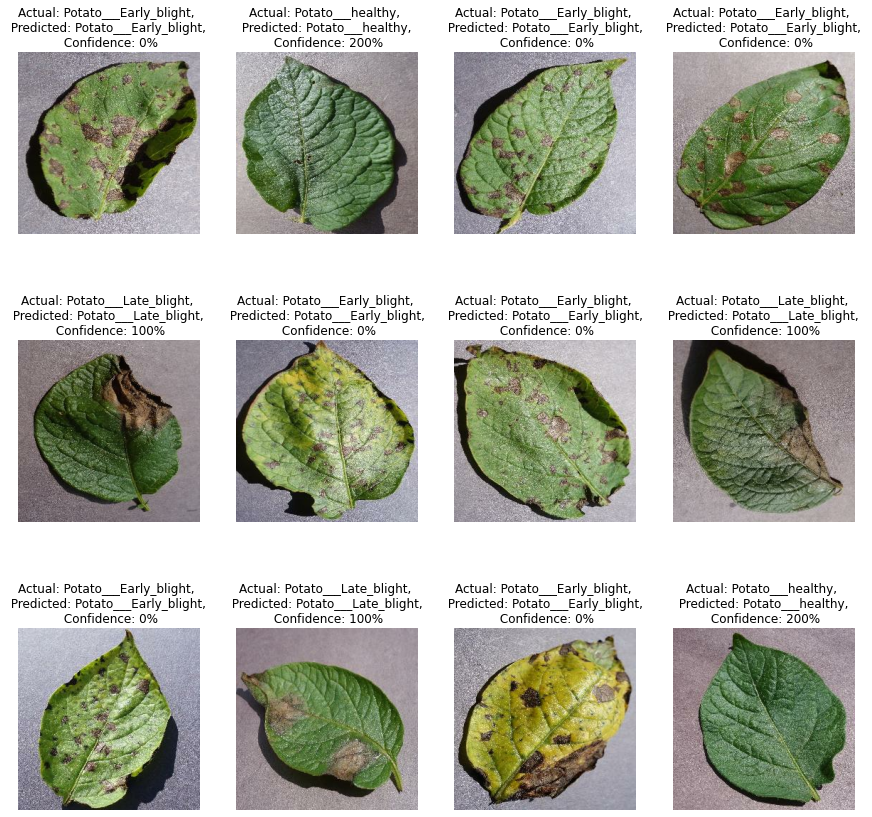

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1): # taking images from the first batch
    for i in range(12):
        ax= plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

# Saving the model

automating the task of version update as soon as we create a new version of this model by either changing layers, neurons, structure, adding more data, etc

In [31]:
import os
model_version = max([int(i) for i in os.listdir("../models")]) + 1
model.save(f"saved_models/{model_version}")

INFO:tensorflow:Assets written to: saved_models/1\assets


INFO:tensorflow:Assets written to: saved_models/1\assets
